In [61]:
import osmnx as ox
import networkx as nx
from pathlib import Path
import pandas as pd
from shapely.geometry import box
import random
import osmnx as ox, shapely.geometry as shg

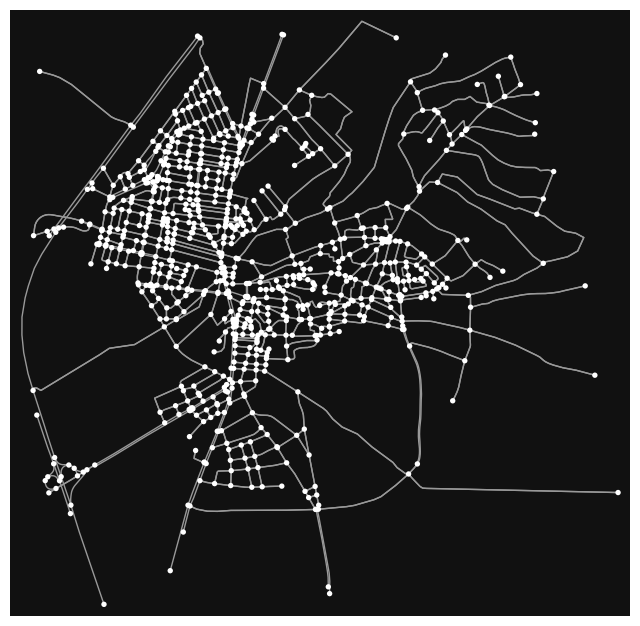

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [62]:
west, south, east, north = 36.71519, 34.00945, 36.74922, 34.03680
poly = box(west, south, east, north)
G = ox.graph_from_polygon(poly,    
                       network_type='drive',
                       retain_all=True,           # ابقِ كل المكوّنات
                       simplify=True,             # تبسيط الهندسة
                       truncate_by_edge=True)     # قصّ الحواف على حدود الـbbox

# عرض سريع (صورة ثابتة)
ox.plot_graph(G)

In [63]:
G = ox.add_edge_speeds(G)        # يضيف speed_kph
G = ox.add_edge_travel_times(G)  # يضيف travel_time (ثواني)

m = ox.plot_graph_folium(G)
m.save("roads_bbox.html")   # افتح الملف بالمتصفح


C:\Users\gubra\AppData\Local\Temp\ipykernel_17456\3438371828.py:4: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  m = ox.plot_graph_folium(G)


In [64]:
A = (36.735, 34.020)  # (lat, lon)
B = (36.745, 34.030)


In [70]:
def random_point_in_bbox(west, south, east, north):
    lon = random.uniform(west,  east)
    lat = random.uniform(south, north)
    return (lat, lon)



def snap_to_road(G, lat, lon):
    # إذا كان G مُسقّط (meters) وانت بتمّرر lat/lon → لازم توحّد CRS (شوف الملاحظة أدناه)
    u, v, k = ox.distance.nearest_edges(G, X=[lon], Y=[lat])[0]
    data = G.get_edge_data(u, v, k)

    geom = data.get("geometry")
    if geom is None:
        # ابني خط مستقيم بين عقدتي الحافة
        x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
        x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
        geom = shg.LineString([(x1, y1), (x2, y2)])

    pt = shg.Point(lon, lat)
    s = geom.project(pt)
    p = geom.interpolate(s)

    # انتبه: إذا G جغرافي (lon/lat) فرجع (lat, lon)،
    # إذا G متري فـ p.x/p.y بالمتر (لازم ترجعهما لنفس CRS اللي بدك ترسمه عليه).
    return (p.y, p.x)  # (lat, lon) عندما تكون إحداثيات العقد بالد

pts = [random_point_in_bbox(west,south,east,north) for _ in range(16)]
snapped_pts = [snap_to_road(G, lat, lon) for lat, lon in pts]
lat_on_road, lon_on_road = map(list, zip(*snapped_pts))


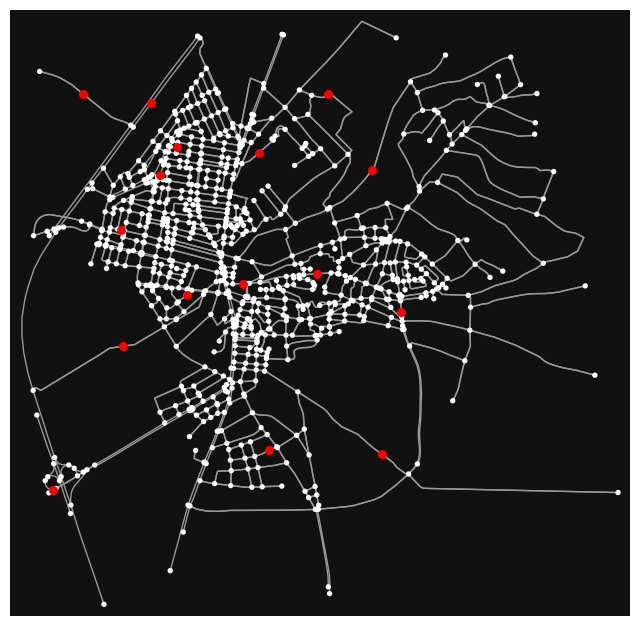

In [71]:
fig, ax = ox.plot_graph(G, show=False, close = False)
ax.scatter(lon_on_road, lat_on_road, s=30, c='red', zorder=5)
fig.savefig("punkter på graph random", dpi=200)

In [ ]:
import osmnx as ox, networkx as nx, folium, numpy as np

def random_point_on_road(G):
    nodes, edges = ox.graph_to_gdfs(G)
    # نختار حافة عشوائية **مرجّحة بالطول** حتى تكون الاحتمالات واقعية
    lengths = edges["length"].values
    probs = lengths / lengths.sum()
    idx = np.random.choice(edges.index, p=probs)
    geom = edges.loc[idx, "geometry"]
    if geom.geom_type != "LineString":
        geom = max(list(geom), key=lambda g: g.length)  # لمجموعة خطوط
    # نقطة عشوائية على الخط
    d = np.random.random() * geom.length
    p = geom.interpolate(d)
    return (p.y, p.x)  # (lat, lon)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# 1) نقطتين عالشارع
A = random_point_on_road(G)
B = random_point_on_road(G)

# 2) أقرب عقد للطريق (للتوجيه)
u = ox.distance.nearest_nodes(G, A[1], A[0])
v = ox.distance.nearest_nodes(G, B[1], B[0])

# 3) مسار (استعمل "travel_time" إذا مضاف، وإلا "length")
weight = "travel_time" if any("travel_time" in d for *_, d in G.edges(data=True)) else "length"
route = nx.shortest_path(G, u, v, weight=weight)

# 4) رسم تفاعلي
m = ox.plot_route_folium(G, route)
folium.Marker(A, tooltip="A (random on road)").add_to(m)
folium.Marker(B, tooltip="B (random on road)").add_to(m)
m.save("random_two_points_route.html")
print("saved -> random_two_points_route.html")


saved -> random_two_points_route.html


C:\Users\gubra\AppData\Local\Temp\ipykernel_17456\276565386.py:32: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  m = ox.plot_route_folium(G, route)
